In [ ]:

!pip install tensorflow keras opencv-python-headless numpy matplotlib
from google.colab import drive
import os

# Mount Drive
drive.mount('/content/drive')

# Dataset path
data_dir = '/content/drive/MyDrive/archive/data'
os.makedirs(data_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224  # MobileNetV2 expects 224x224

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3102 images belonging to 4 classes.
Found 774 images belonging to 4 classes.


In [ ]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint('best_model_mobilenetv2.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)

# Load best model
model = tf.keras.models.load_model('best_model_mobilenetv2.h5')

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4881 - loss: 1.3447

97/97 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.4891 - loss: 1.3421 - val_accuracy: 0.8398 - val_loss: 0.4424
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7199 - loss: 0.7137

97/97 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.7201 - loss: 0.7132 - val_accuracy: 0.8811 - val_loss: 0.3289
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7863 - loss: 0.5454

97/97 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.7863 - loss: 0.5453 - val_accuracy: 0.8837 - val_loss: 0.2968
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8055 - loss: 0.4712

97/97 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.8056 - loss: 0.4712 - val_accuracy: 0.8902 - val_loss: 0.2714
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.8166 - loss: 0.4644 - val_accuracy: 0.8824 - val_loss: 0.2872
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8265 - loss: 0.4128

97/97 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.8265 - loss: 0.4129 - val_accuracy: 0.9044 - val_loss: 0.2567
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.8317 - loss: 0.4038 - val_accuracy: 0.8889 - val_loss: 0.2671
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.8577 - loss: 0.3713 - val_accuracy: 0.8941 - val_loss: 0.2694
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.8574 - loss: 0.3479 - val_accuracy: 0.8953 - val_loss: 0.2468
Epoch 10/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.8578 - loss: 0.3553 - val_accuracy: 0.8953 - val_loss: 0.2432
Epoch 11/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.8634 - loss: 0.3572 - val_accuracy: 0.9044 - val_loss: 0.2391
Epoch 12/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.8637 - loss: 0.3380 - val_accuracy: 0.8992 - val_loss: 0.2345
Epoch 13/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.8646 - loss: 0.3340 - val_accuracy: 0.9018 - val_loss

97/97 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.8706 - loss: 0.3190 - val_accuracy: 0.9147 - val_loss: 0.2493
Epoch 17/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.8642 - loss: 0.3229 - val_accuracy: 0.8941 - val_loss: 0.2448


In [ ]:

import cv2
import matplotlib.pyplot as plt
import numpy as np

class_labels = list(train_gen.class_indices.keys())

def predict_and_highlight(image_path, model):
    original_img = cv2.imread(image_path)
    if original_img is None:
        print("Image not found.")
        return

    # Resize and normalize
    img_resized = cv2.resize(original_img, (img_size, img_size))
    img_input = np.expand_dims(img_resized / 255.0, axis=0)

    # Predict
    pred = model.predict(img_input)[0]
    top_class = np.argmax(pred)
    confidence = pred[top_class] * 100
    label = class_labels[top_class]

    # Highlight for "blight"
    display_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    if label.lower() == "blight":
        gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            if cv2.contourArea(c) > 200:  # Filter noise
                x, y, w, h = cv2.boundingRect(c)
                cv2.rectangle(display_img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Show
    plt.imshow(display_img)
    plt.axis('off')
    plt.title(f"Prediction: {label} ({confidence:.2f}%)")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


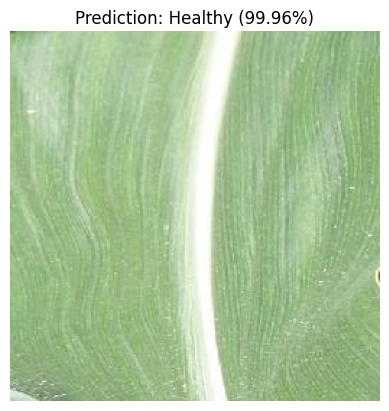

In [ ]:
predict_and_highlight('/content/drive/MyDrive/archive/data/Healthy/Corn_Health (30).jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


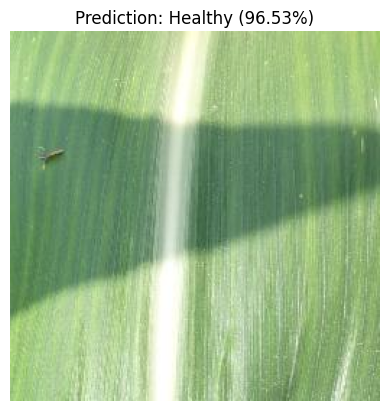

In [ ]:
predict_and_highlight('/content/drive/MyDrive/archive/data/Healthy/Corn_Health (20).jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


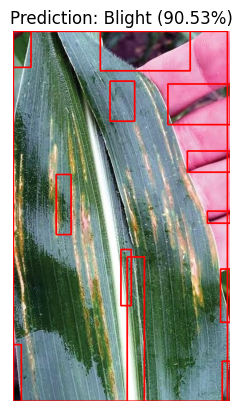

In [ ]:
predict_and_highlight('/content/drive/MyDrive/archive/data/Blight/Corn_Blight (30).jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


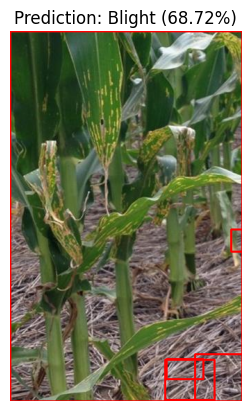

In [ ]:
predict_and_highlight('/content/drive/MyDrive/archive/data/Blight/Corn_Blight (41).jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


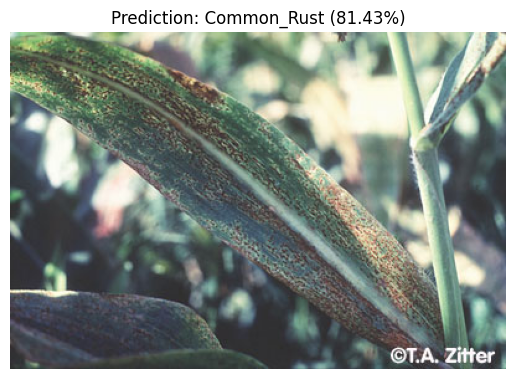

In [ ]:
predict_and_highlight('/content/drive/MyDrive/archive/data/Common_Rust/Corn_Common_Rust (41).jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


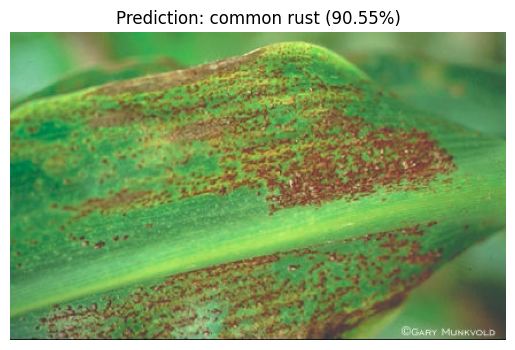

In [ ]:
predict_and_highlight('/content/drive/MyDrive/archive/data/Common_Rust/Corn_Common_Rust (4).jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


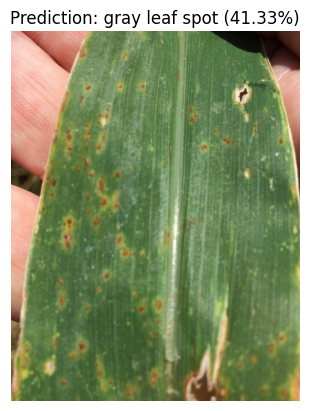

In [ ]:
predict_and_highlight('/content/drive/MyDrive/archive/data/Common_Rust/Corn_Common_Rust (18).jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


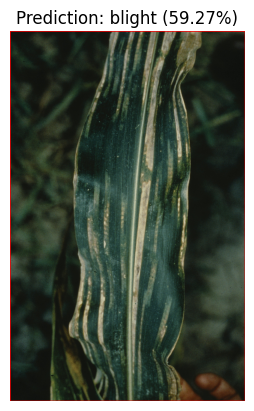

In [ ]:
predict_and_highlight('/content/drive/MyDrive/archive/data/Blight/Corn_Blight (34).jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


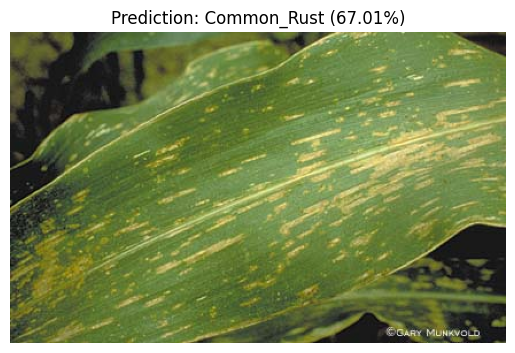

In [ ]:
predict_and_highlight('/content/drive/MyDrive/archive/data/Gray_Leaf_Spot/Corn_Gray_Spot (7).jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


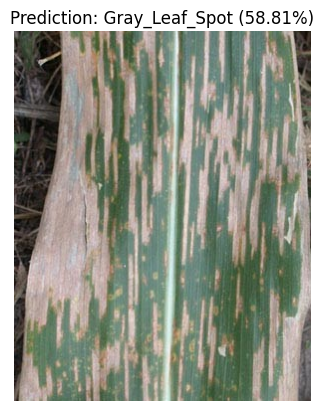

In [ ]:
predict_and_highlight('/content/drive/MyDrive/archive/data/Gray_Leaf_Spot/Corn_Gray_Spot (3).jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


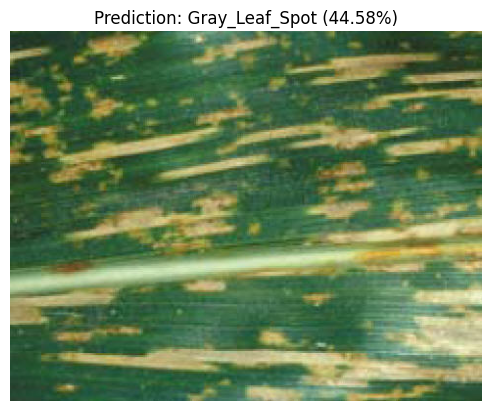

In [ ]:
predict_and_highlight('/content/drive/MyDrive/archive/data/Gray_Leaf_Spot/Corn_Gray_Spot (30).jpg', model)

In [ ]:
!pip install gradio tensorflow keras opencv-python-headless matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.8 MB/s eta 0:00:00


In [ ]:

import tensorflow as tf

model = tf.keras.models.load_model('best_model_mobilenetv2.h5')

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

class_labels = ['blight', 'common rust', 'gray leaf spot', 'healthy']
img_size = 224

def predict_and_annotate(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    original = image.copy()

    # Resize and normalize
    img_resized = cv2.resize(image, (img_size, img_size)) / 255.0
    img_input = np.expand_dims(img_resized, axis=0)

    # Predict
    pred = model.predict(img_input)[0]
    top_idx = np.argmax(pred)
    label = class_labels[top_idx]
    confidence = float(pred[top_idx]) * 100

    # If blight, highlight spots
    if label == "blight":
        gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            if cv2.contourArea(c) > 200:
                x, y, w, h = cv2.boundingRect(c)
                cv2.rectangle(original, (x, y), (x+w, y+h), (0, 0, 255), 2)

    output = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    return output, f"Prediction: {label} ({confidence:.2f}%)"

In [ ]:

import gradio as gr

interface = gr.Interface(
    fn=predict_and_annotate,
    inputs=gr.Image(type="numpy", label="Upload a Leaf Image"),
    outputs=[gr.Image(label="Detected Image"), gr.Label(label="Prediction")],
    title="Plant Disease Detector",
    description="Detects plant leaf diseases like blight, common rust, and gray leaf spot using MobileNetV2."
)

interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7ad4f68e059ab09368.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:

import tensorflow as tf
from tensorflow.keras import layers, Model

def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b1)

    # Decoder
    u2 = layers.UpSampling2D((2, 2))(b1)
    u2 = layers.concatenate([u2, c2])
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u3 = layers.UpSampling2D((2, 2))(c3)
    u3 = layers.concatenate([u3, c1])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    return Model(inputs, outputs)

In [ ]:

# STEP 1: Install required packages
!pip install tensorflow opencv-python-headless matplotlib

# STEP 2: Imports and paths
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from google.colab import files
# Import the google.colab.drive module
from google.colab import drive

# Set your paths here
drive.mount('/content/drive')
# Check if the 'Blight' folder exists under '/content/drive/MyDrive/archive/data'.
# If not, adjust the path accordingly.
image_dir = '/content/drive/MyDrive/archive/data/Blight'
# Example: If the folder is named 'blight', change to:
# image_dir = '/content/drive/MyDrive/archive/data/blight'
mask_dir = '/content/drive/MyDrive/masks'
os.makedirs(mask_dir, exist_ok=True)

# STEP 3: Auto-generate masks using HSV thresholding
def generate_mask(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_blight = np.array([10, 40, 40])
    upper_blight = np.array([35, 255, 255])
    mask = cv2.inRange(hsv, lower_blight, upper_blight)
    mask = cv2.medianBlur(mask, 5)
    return mask

# ... (rest of the code remains the same)

ValueError: Mountpoint must not already contain files